# Análisis Geoespacial de Hurtos a Persona en Medellín - 2018
Este notebook presenta un análisis descriptivo y geoespacial de los delitos de hurto a persona en Medellín durante el año 2018, utilizando datos abiertos. El objetivo es explorar patrones espaciales mediante visualización con coordenadas geográficas.

In [ ]:
'''
%pip install matplotlib
%pip install geopandas
%pip install shapely
%pip install osmnx
%pip install contextily
%pip install seaborn
%pip install pyarrow
%pip install pandas
%pip install scikit-learn
'''

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.1 MB 2.4 MB/s eta 0:00:05
   ------ --------------------------------- 1.8/11.1 MB 2.5 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.1 MB 2.5 MB/s eta 0:00:04
   ---------- ----------------------------- 2.9/11.1 MB 2.5 MB/s eta 0:00:04
   ----------- ---------------------------- 3.1/11.1 MB 2.5 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/11.1 MB 2.3 MB/s eta 0:00:04
   --------------- ------------------------ 4.2/11.1 MB 2.3 MB/s eta 0:00:04
   ---------------- ----------------------- 4.5/11.1 MB 2.2 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.1 MB 2.2 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.1 MB 2.2 MB/s eta 0:00:03
   ----------


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns
import contextily as ctx
from sklearn.cluster import DBSCAN
# Set the style for seaborn
plt.style.use('seaborn-v0_8')

## Carga y visualización inicial de los datos

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_parquet('.\data\hurto_a_persona.parquet.gzip',engine='pyarrow')
df.head(3)

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,ocupacion,discapacidad,grupo_especial,medio_transporte,nivel_academico,testigo,conducta,modalidad,caracterizacion,conducta_especial,arma_medio,articulo_penal,categoria_penal,nombre_barrio,codigo_barrio,codigo_comuna,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
0,2018-01-01T20:30:00.000-05:00,1.0,6.278325,-75.601265,Mujer,65,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Taxi,Sin dato,Sin dato,Hurto a persona,Atraco,Sin dato,Sin dato,Arma de fuego,Sin dato,Sin dato,Cucaracho,#0718,7,Vía pública,Castilla,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00
1,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Visa,Documentos,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00
2,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00


## Conversión de tipos de datos y limpieza

In [4]:
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'], errors='coerce')
df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
df = df.dropna(subset=['latitud', 'longitud'])
df.shape

(257026, 36)

In [5]:
# Filtro geográfico por límites conocidos de Medellín
df_clean = df[
    (df['latitud'] >= 6.15) & (df['latitud'] <= 6.40) &
    (df['longitud'] >= -75.70) & (df['longitud'] <= -75.45)
].copy()



## Creación de geometría tipo punto para análisis geoespacial

In [6]:
geometry = [Point(xy) for xy in zip(df_clean['longitud'], df_clean['latitud'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')
gdf.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,ocupacion,discapacidad,grupo_especial,medio_transporte,nivel_academico,testigo,conducta,modalidad,caracterizacion,conducta_especial,arma_medio,articulo_penal,categoria_penal,nombre_barrio,codigo_barrio,codigo_comuna,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion,geometry
0,2018-01-01 20:30:00-05:00,1.0,6.278325,-75.601265,Mujer,65,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Taxi,Sin dato,Sin dato,Hurto a persona,Atraco,Sin dato,Sin dato,Arma de fuego,Sin dato,Sin dato,Cucaracho,#0718,7,Vía pública,Castilla,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.60127 6.27832)
1,2018-01-02 18:30:00-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Visa,Documentos,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
2,2018-01-02 18:30:00-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
3,2018-01-02 18:30:00-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta para computador,Tecnología,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
4,2018-01-02 18:30:00-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)


## Exploración de datos

Text(0.5, 1.0, 'Top 10 Conductas de Hurto a Persona')

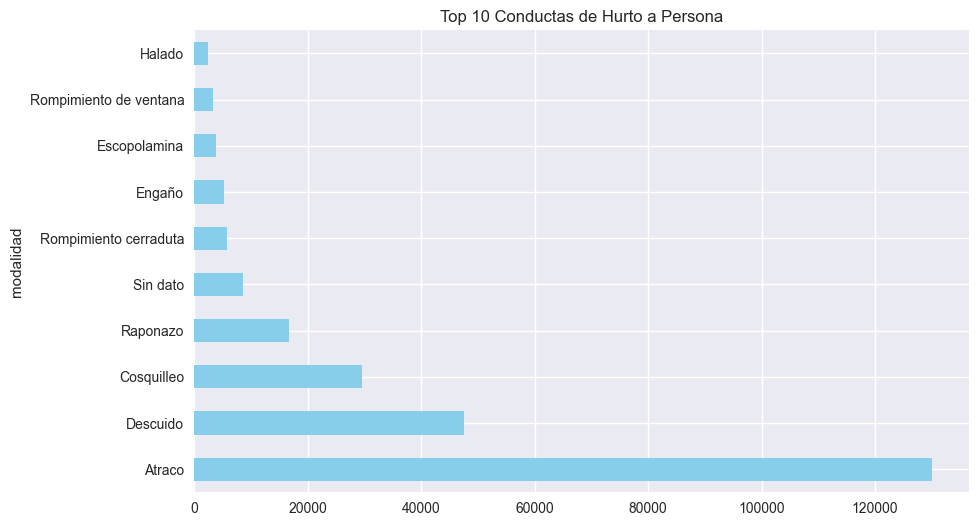

In [8]:
gdf['modalidad'].value_counts().head(10).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Conductas de Hurto a Persona')

Text(0.5, 1.0, 'Top 10 Bienes hurtados a persona')

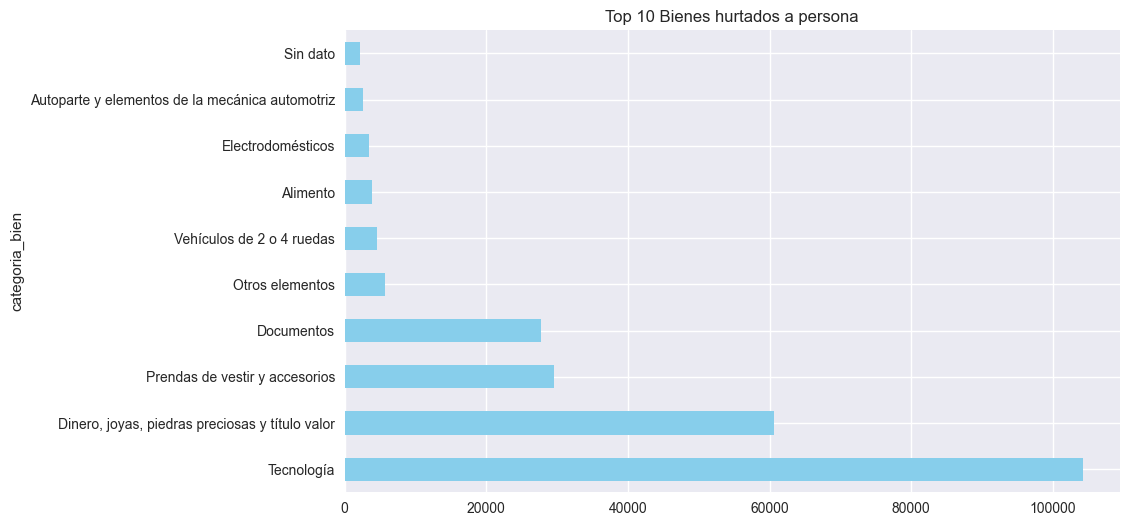

In [9]:
gdf['categoria_bien'].value_counts().head(10).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Bienes hurtados a persona')

In [10]:
print(gdf['fecha_hecho'].min(), gdf['fecha_hecho'].max())

2003-01-02 11:00:00-05:00 2022-04-30 23:05:00-05:00


## Visualización inicial de la distribución geográfica de los hurtos

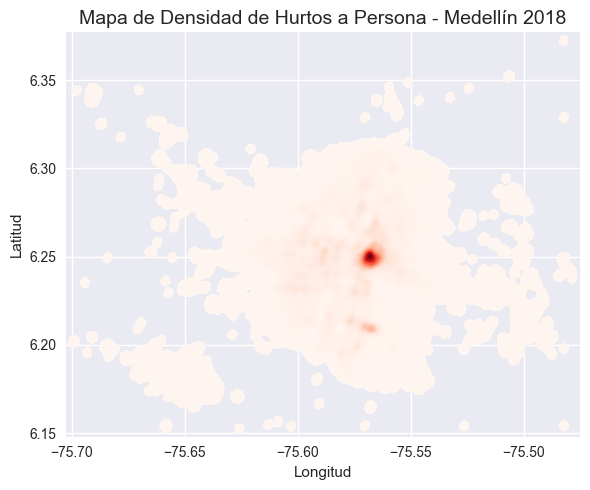

In [ ]:
df_plot = gdf[['latitud', 'longitud']].dropna()

# Crear heatmap con KDE de seaborn
plt.figure(figsize=(6, 5))
sns.kdeplot(
    data=df_plot,
    x='longitud',
    y='latitud',
    fill=True,
    cmap='Reds',
    thresh=0.0001,  # Reduced threshold to include more data
    bw_adjust=0.5,
    levels=100
)

plt.colorbar(label='Densidad de Hurtos')
plt.title('Mapa de Densidad de Hurtos a Persona - Medellín 2018', fontsize=14)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.tight_layout()
plt.show()

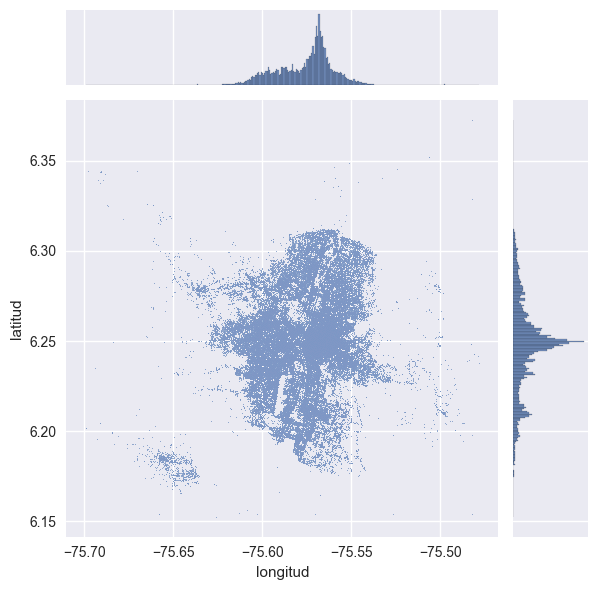

In [25]:
# Generate scatter plot
sns.jointplot(x='longitud', y='latitud', data=gdf, s=0.5);

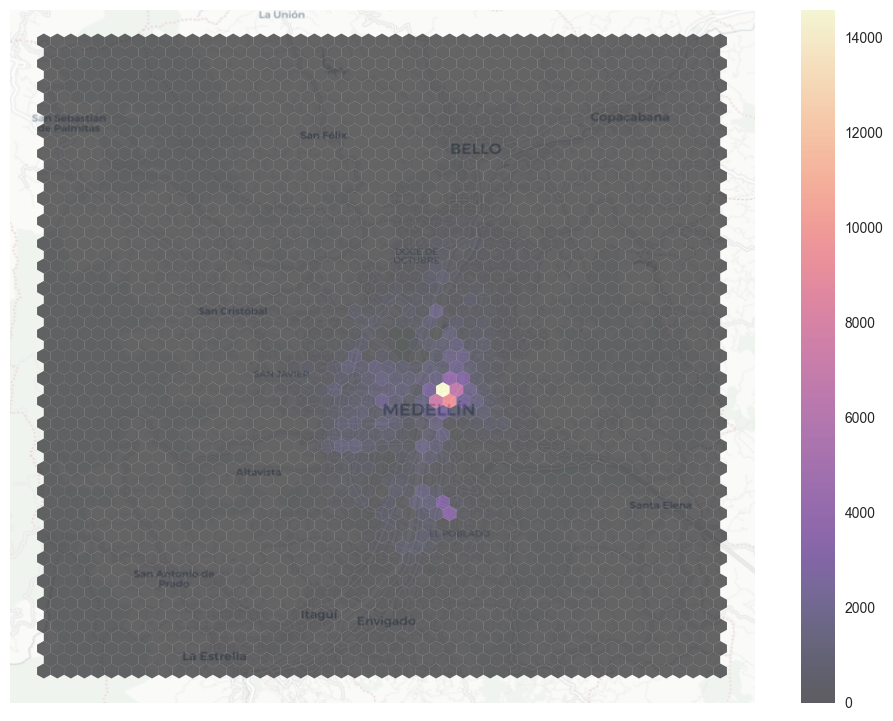

In [36]:
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each dimension, no borderlines, half transparency
hb = ax.hexbin(
    df_clean['longitud'], 
    df_clean['latitud'],
    gridsize=50, 
    linewidths=0,
    alpha=0.6, 
    cmap='magma'
)
# Add basemap
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron,
    zoom=12,
    crs=gdf.crs.to_string(),
    attribution=False
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

c:\Users\johanmum\OneDrive - Universidad Nacional de Colombia\UNAL\AnalisisGeo\proyecto_analisis_geoespacial\.venv\Lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


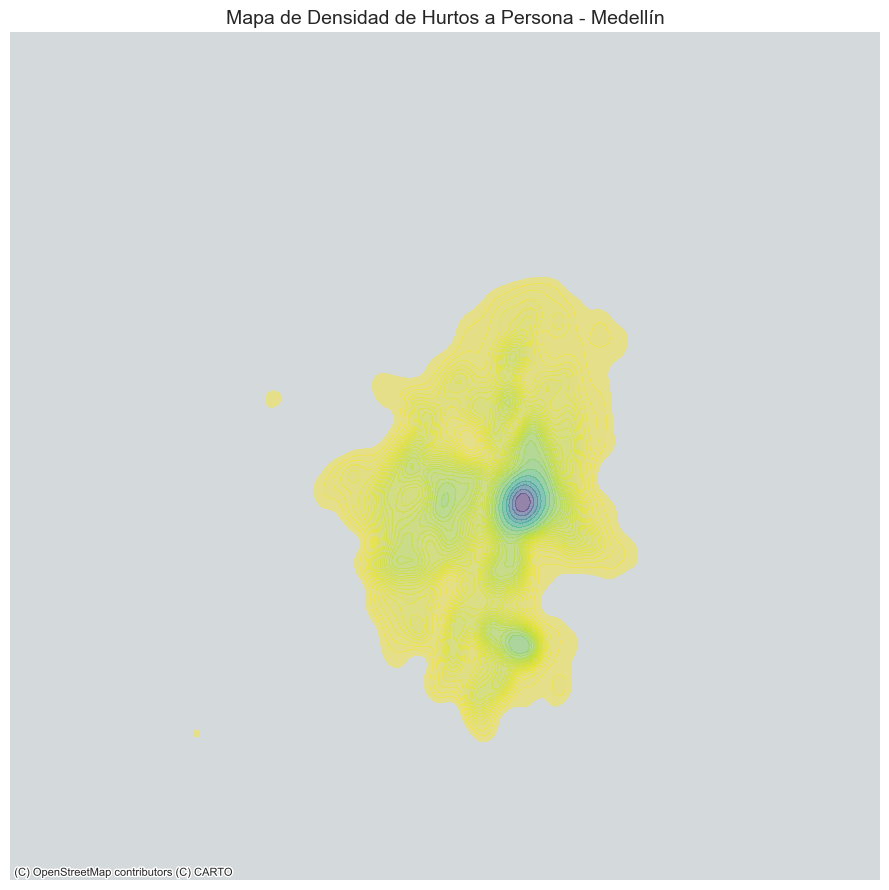

In [40]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
sns.kdeplot(x=gdf['longitud'],y=gdf['latitud'],n_levels=30,fill=True,alpha=0.45,cmap='viridis_r')
# Add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
# Remove axes
ax.set_axis_off()

plt.title('Mapa de Densidad de Hurtos a Persona - Medellín', fontsize=14)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Hurtos a Persona en Medellín')

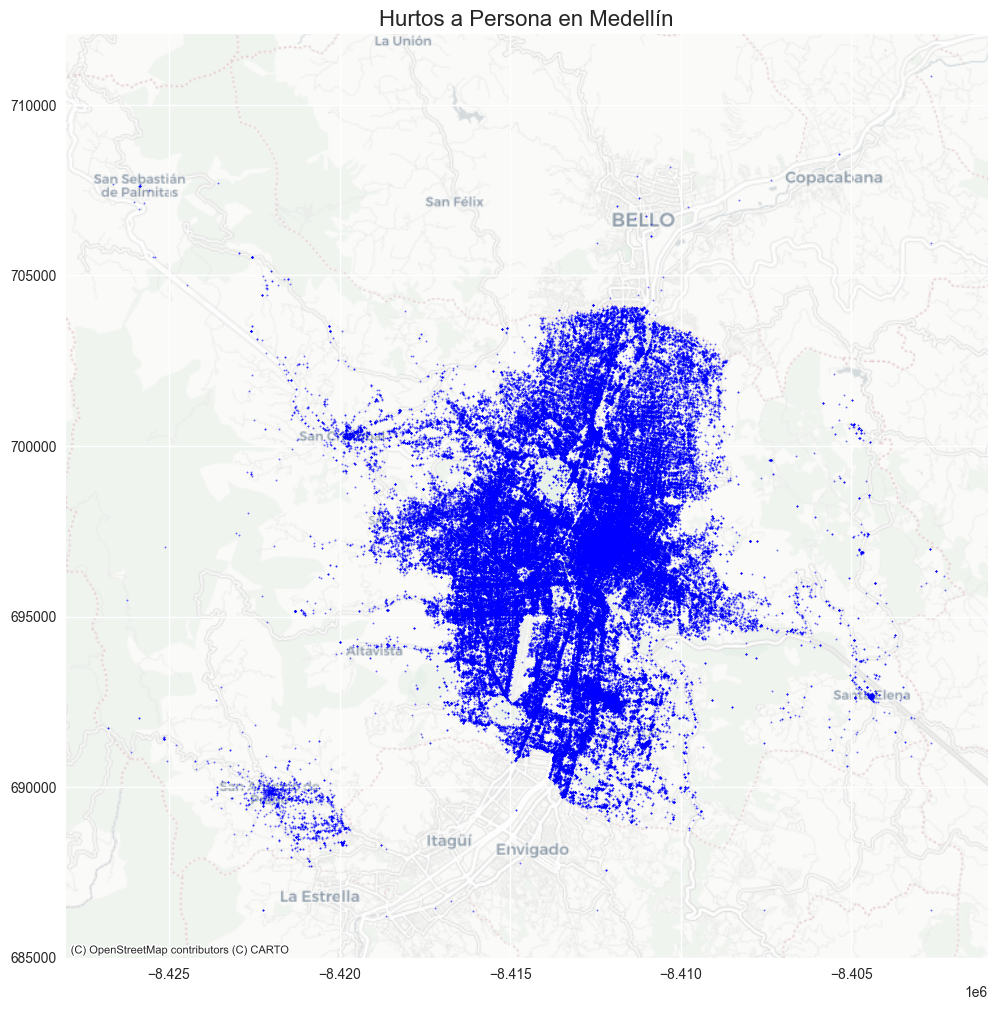

In [ ]:
# Create a GeoDataFrame with the points
gdf = gdf.to_crs(epsg=3857)  # Convert to Web Mercator for OSM
# Create a scatter plot of the points
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.5)
# Add a basemap 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title('Hurtos a Persona en Medellín', fontsize=16)

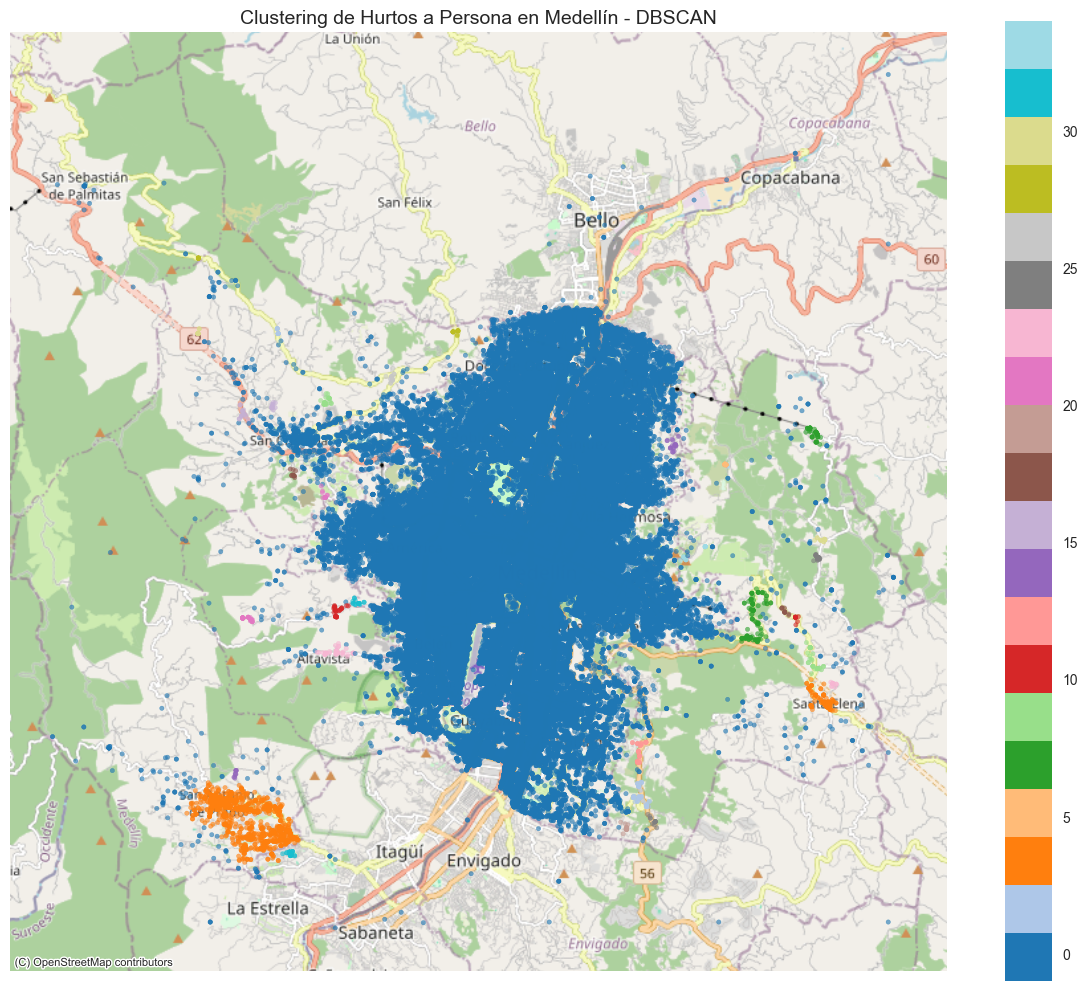

In [7]:

# --- 2. Proyectar a metros (EPSG:3857 para mapas web) ---
gdf = gdf.to_crs(epsg=3857)

# Extraer coordenadas X/Y para clustering

coords = list(zip(gdf.geometry.x, gdf.geometry.y))

# --- 3. Clustering con DBSCAN ---
db = DBSCAN(eps=200, min_samples=10).fit(coords)  # 200 metros de radio
gdf['cluster'] = db.labels_

# --- 4. Visualizar resultados ---
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='cluster', cmap='tab20', legend=True, markersize=10, alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Clustering de Hurtos a Persona en Medellín - DBSCAN", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()